# Starter code - HW 3: BNN + BBVI - YOUR NAME HERE

For the original HW3 Instructions from Fall 2022:

https://www.cs.tufts.edu/cs/152BDL/2022f/hw3.html

#### Collaboration statement

My name is TODO FILL, and I worked with TODO FILL

# Clickable Table of Contents

#### Problem 0: Implementing BBVI

* 0a: [sample_nn_params_from_q](#sample_nn_params_from_q)
* 0b: [calc_logpdf_q](#calc_logpdf_q)
* 0c: [calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick](#calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick)
* 0d: [optimize_q_via_stochastic_gradient_ascent](#optimize_q_via_stochastic_gradient_ascent)

#### Problem 1: Diagnostic plots of estimated ELBO and gradients

Verifies your implementation of `calc_logpdf_q` and `calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick`

* [Problem 1a](#problem-1a)
* [Problem 1b](#problem-1b)
* [Problem 1c](#problem-1c)
* [Problem 1d](#problem-1d)
* [Problem 1e](#problem-1e)

#### Problem 2: Run BBVI on COVID-19 data with arch [ ]

Uses `optimize_q_via_stochastic_gradient_ascent`

* [Fig 2a with caption](#problem-2a)
* [Fig 2b with caption](#problem-2b)

#### Problem 3: Run BBVI on COVID-19 data with arch [8]

Uses `optimize_q_via_stochastic_gradient_ascent`

* [Fig 3a with caption](#problem-3a)
* [Fig 3b with caption](#problem-3b)

# Setup

## Import Statements

In [1]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import copy, datetime, time, os, platform

In [2]:
## Import JAX
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats

In [3]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Print system info

Useful for debugging

In [4]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: tufts-wifi-10-5-4-240.eecs.tufts.edu
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


In [5]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


## Colab Setup

### If you are on Google Colab, set `using_colab = True'

Then will clone the github and give you access to the extra .py files and the dataset CSV in starter code

### If not, don't need to do anything as long as you're running in the hw2 directory from starter code


In [81]:
using_colab = False

In [82]:
if using_colab:
    if not os.path.exists('cs152BDL-22f-assignments/hw3/'):
        !git clone https://github.com/tufts-ml-courses/cs152BDL-22f-assignments.git 
    os.chdir('cs152BDL-22f-assignments/hw3/')

In [83]:
# List .py files in current directory, for debugging purposes
# Should see neural_net_utils.py and other .py files from starter code repo

!ls *.py

neural_net_regression_model.py        pytree_arithmetic_utils.py
neural_net_utils.py                   viz_utils_for_posterior_predictive.py


In [84]:
# List .csv files in current directory, for debugging purposes
# Should see the COVID-19 data file in the starter code repo

!ls *.csv

avg_deaths_per_day_in_middlesex_ma_2021__test.csv
avg_deaths_per_day_in_middlesex_ma_2021__train.csv
middlesex_ma_2021_deaths.csv


## Import utility functions from starter code's external .py files

In [6]:
from pytree_arithmetic_utils import (
    add_pytrees,
    multiply_pytree_and_scalar,
    subtract_pytree_and_scalar, subtract_pytrees)

In [7]:
import neural_net_utils

make_nn_params_as_list_of_dicts = neural_net_utils.make_nn_params_as_list_of_dicts
pretty_print_nn_param_list = neural_net_utils.pretty_print_nn_param_list
predict_f_given_x = neural_net_utils.predict_f_given_x

In [8]:
import neural_net_regression_model as model

calc_logpdf_likelihood = model.calc_logpdf_likelihood
calc_logpdf_prior = model.calc_logpdf_prior
sample_nn_params_from_prior = model.sample_nn_params_from_prior

fast_logpdf_likelihood = jax.jit(calc_logpdf_likelihood)
fast_logpdf_prior = jax.jit(calc_logpdf_prior)

In [9]:
import viz_utils_for_posterior_predictive as viz_utils

## Fix model hyperparameters

In [10]:
model_hypers = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0,
    'tau':0.3}

In [11]:
W, H = 6, 4  # set width/height of each panel

## Load COVID-19 data from Middlesex County, MA in 2021

Source: NYTimes COVID-19 data on GitHub

Distributed as part of HW3's starter code

In [12]:
df = pd.read_csv('avg_deaths_per_day_in_middlesex_ma_2021__train.csv')

In [13]:
raw_x_NF = df['days_since_211207'].astype(np.float32).values[:,np.newaxis].copy()
raw_y_N = df['deaths_avg'].astype(np.float32).values.copy()

In [14]:
def standardize_array_by_columns(a):
    return (a - np.mean(a, axis=0, keepdims=1)) / np.std(a, axis=0, keepdims=1)

standard_x_NF = standardize_array_by_columns(raw_x_NF)
standard_y_N = standardize_array_by_columns(raw_y_N)

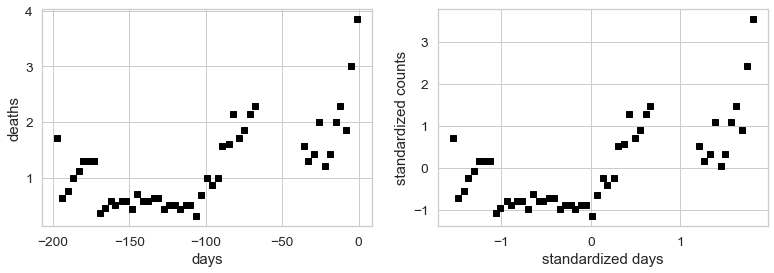

In [15]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(W*2+1, H),
                         sharey=False, sharex=False)
axgrid[0].plot(raw_x_NF, raw_y_N, 'ks');
axgrid[0].set_xlabel('days')
axgrid[0].set_ylabel('deaths')
axgrid[1].plot(standard_x_NF, standard_y_N, 'ks');
axgrid[1].set_xlabel('standardized days');
axgrid[1].set_ylabel('standardized counts');

plt.savefig('avg_deaths_per_day_before_after_standardization.png')

In [16]:
# Use standardized data

x_NF = 1.0 * standard_x_NF
y_N = 1.0 * standard_y_N

### Create test grid of x values (size T) to use to visualize predictions

In [17]:
T = 501
xrange = (np.max(x_NF) - np.min(x_NF))
xlo = x_NF.min() - 0.1 * xrange
xhi = x_NF.max() + 0.3 * xrange # show more forward in time
x_grid_T = np.linspace(xlo, xhi, T)
x_grid_T1 = x_grid_T.reshape((T,1))

In [18]:
print(x_grid_T[:10], '...', x_grid_T[-10:])

[-1.87405863 -1.86467815 -1.85529767 -1.84591719 -1.83653671 -1.82715623
 -1.81777575 -1.80839527 -1.7990148  -1.78963432] ... [2.73175659 2.74113706 2.75051754 2.75989802 2.7692785  2.77865898
 2.78803946 2.79741994 2.80680042 2.8161809 ]


## Softplus : Functions to transform from reals to positives

Used to parameterize our standard deviations, as recommended in the Bayes-by-Backprop paper

In [19]:
def softplus(a):
    return jnp.log(1+jnp.exp(a))

In [20]:
def invsoftplus(b):
    return jnp.log(jnp.exp(b) - 1)

Verify that `softplus` and `invsoftplus` really do invert one another, mapping an input back to its original value.

In [21]:
invsoftplus(softplus(-3.0))

DeviceArray(-3.0000005, dtype=float32, weak_type=True)

## Elementwise softplus of a pytree 

In [22]:
def softplus_of_pytree(pytree):
    return jax.tree_map(lambda a: jax.nn.softplus(a), pytree)

## Utility to fill pytree with draws from Normal 

In [23]:
def fill_q_params_with_draws_from_normal(
        n_dims_input=1,
        n_dims_output=1,
        n_dims_per_hidden_list=[],
        mean=0.0,
        stddev=1.0,
        random_state=101):
    ''' Create pytree of parameters for q
    
    Args
    ----
    n_dims_input : int
    n_dims_output : int
    n_dims_per_hidden_list : list of int
    mean : scalar float
    stddev : scalar float
    random_state : int or np.random.RandomState
    
    Returns
    -------
    m_params : Pytree
    '''
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)
    def fill_func(shape):
        return random_state.normal(mean, stddev, size=shape)
    return make_nn_params_as_list_of_dicts(
        n_dims_input, n_dims_output, n_dims_per_hidden_list,
        weight_fill_func=fill_func,
        bias_fill_func=fill_func)
    

# Problem 0: Implementing BBVI

<a id="sample_nn_params_from_q"></a>

## 0a: Write function to sample nn_params (as pytree) from q

In [24]:
def sample_nn_params_from_q(
        q_mean_params, q_realstddev_params,
        random_state=42,
        n_samples=1):
    """ Sample values of weights/biases given a specific approx. posterior q
    
    Args
    ----
    q_mean_params : pytree
    q_realstddev_params : pytree
    n_samples : int
    
    Returns
    -------
    nn_params : list of pytree 
        Each element is a nn_params list-of-dicts
    """
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)
        
    all_nn_samples = list()
    L = len(q_mean_params)
    for sample_id in range(n_samples):
        cur_nn_params = list()
        for layer_id in range(L):
            # TODO draw weights/biases for this layer from a Normal
            # with mean determined by contents of q_mean_params
            # with stddev determined by *transformation* of q_realstddev_params
            # HINT: Look at softplus or softplus_of_pytree
            
            w_mean_UV = q_mean_params[layer_id]['w']
            w_UV = np.zeros(w_mean_UV.shape) # FIXME draw from normal

            b_mean_V = q_mean_params[layer_id]['b']
            b_V = np.zeros(b_mean_V.shape) # FIXME draw from normal
            
            # w_UV is the sampled weights for this layer
            # b_V is array of sampled biases for this layer
            # Pack them away into our list-of-dicts pytree format
            cur_nn_params.append(dict(w=w_UV, b=b_V))
        all_nn_samples.append(cur_nn_params)
    return all_nn_samples

### Quick test of `sample_nn_params_from_q`

In [25]:
# 1) Create means from Normal 
q_mean_params = fill_q_params_with_draws_from_normal(
    1, 1, [], mean=0.0, stddev=1.0, random_state=101)
pretty_print_nn_param_list(q_mean_params, prefix='mean-of-')

Layer 0
  mean-of-w | shape    (1, 1) | [ 2.707]
  mean-of-b | shape      (1,) | [ 0.628]


In [26]:
# 2) Create realstddevs that typically map to a stddev around 0.1
q_realstddev_params = fill_q_params_with_draws_from_normal(
    1, 1, [], mean=invsoftplus(0.1), stddev=0.01, random_state=102)
pretty_print_nn_param_list(q_realstddev_params, prefix='rstd-of-')

Layer 0
  rstd-of-w | shape    (1, 1) | [-2.235]
  rstd-of-b | shape      (1,) | [-2.243]


In [27]:
# 2b) Map realstddev values to stddev params
pretty_print_nn_param_list(softplus_of_pytree(q_realstddev_params), prefix='std-of-')

Layer 0
  std-of-w | shape    (1, 1) | [ 0.102]
  std-of-b | shape      (1,) | [ 0.101]


Now, use the above to draw 10 samples from q

Use the method you just defined: `sample_nn_params_from_q`

In [28]:
# 3) Draw 10 samples from q defined by the parameters above
nn_samples_S = sample_nn_params_from_q(
    q_mean_params, q_realstddev_params,
    random_state=42,
    n_samples=10)

In [29]:
print("==== SAMPLE 0")
pretty_print_nn_param_list(nn_samples_S[0])

==== SAMPLE 0
Layer 0
  w | shape    (1, 1) | [ 0.000]
  b | shape      (1,) | [ 0.000]


In [30]:
print("==== SAMPLE 1")
pretty_print_nn_param_list(nn_samples_S[1])

==== SAMPLE 1
Layer 0
  w | shape    (1, 1) | [ 0.000]
  b | shape      (1,) | [ 0.000]


Your samples should look like draws from a Normal with mean/stddev reported in lines above

<a id="calc_logpdf_q"></a>

## 0b: Write function to evaluate logpdf of q

In [31]:
def calc_logpdf_q(nn_params, q_mean_params, q_realstddev_params):
    """ Compute logpdf of provided nn weights under q
    
    Args
    ----
    nn_params : pytree
    q_mean_params : pytree, same shape as `nn_params`
    q_realstddev_params : pytree, same shape as `nn_params`
    
    Returns
    -------
    logpdf_q : scalar float
    """
    L = len(nn_params)
    total_logpdf = 0.0
    
    # TODO compute logpdf of q evaluated at nn_params
    # with q a Normal distribution whose params are set to:
    # m = q_mean_params
    # r = q_realstddev_params (convert into stddev via softplus)

    # HINT: Loop over layers 0, 1, ... L-1
    # at each one, grab the w array and b array
    # then plug that into jstats.norm.logpdf
    
    return total_logpdf

### Quick test of `calc_logpdf_q`

Should be able to ask about the logpdf of each of the 10 samples from our earlier quick test

In [32]:
calc_logpdf_q(nn_samples_S[0], q_mean_params, q_realstddev_params)

0.0

In [33]:
calc_logpdf_q(nn_samples_S[1], q_mean_params, q_realstddev_params)

0.0

### Function to compute value and gradient of logpdf_q

In [34]:
# Function to calculate the value of the q logpdf AND its gradients in one call

# Remember that calc_logpdf_q takes args (nn_params, q_means, q_realstddevs)
# so we want grad wrt args numbered 1 and 2 index order (start counting from 0)
calc_value_and_grad_of_logpdf_q = jax.value_and_grad(calc_logpdf_q, argnums=[1,2])
fast_value_and_grad_of_logpdf_q = jax.jit(calc_value_and_grad_of_logpdf_q)

### Quick test of `fast_value_and_grad_of_logpdf_q`

In [35]:
logpdf, (g_m, g_rs) = fast_value_and_grad_of_logpdf_q(nn_samples_S[1], q_mean_params, q_realstddev_params)
pretty_print_nn_param_list(g_m, prefix='grad-wrt-mean-')
pretty_print_nn_param_list(g_rs, prefix='grad-wrt-realstddev-')

Layer 0
  grad-wrt-mean-w | shape    (1, 1) | [ 0.000]
  grad-wrt-mean-b | shape      (1,) | [ 0.000]
Layer 0
  grad-wrt-realstddev-w | shape    (1, 1) | [ 0.000]
  grad-wrt-realstddev-b | shape      (1,) | [ 0.000]


## Prep for 0c: Calculate Monte-Carlo (MC) estimate of the ELBO

Verify that you know how to do a MC estimate of the ELBO
This will help you prepare for 0c's `calc_elbo_and_grad_from_mc_samples`

That is, your goal is to implement a function that takes in $S$ samples of the weights-and-biases $\{z^s\}_{s=1}^S$, each drawn iid from $q$ like so:

$$
z^s \sim q( z ; m, r), \hspace{10cm}
$$

Given these $S$ samples, we wish to return a Monte-Carlo estimate of the ELBO

\begin{align}
\mathcal{L}(m, r) &\approx
    \frac{1}{S} \sum_{s=1}^S 
    \Big( \log p(y_{1:N}, z^s) - \log q(z^s ; m, r) 
    \Big)  \hspace{10cm}
\end{align}

Remember that you can compute the **joint** logpdf of $y$ and $z$ by combining the logpdf of likelihood with logpdf of the prior.



In [36]:
def calc_elbo_from_mc_samples(
        nn_samples_S,
        q_mean_params, q_realstddev_params,
        ):
    """ Estimate the ELBO of q given S samples of nn_params
    
    Args
    ----
    nn_samples_S : list of pytree, length S
    q_mean_params : pytree, same shape as one entry of `nn_samples_S`
        Defines q's mean parameters at each weight/bias
    q_realstddev_params : pytree, same shape as `q_mean_params`
        Defines q's realstddev parameters at each weight/bias

    Returns
    -------
    elbo : scalar float
    """
    S = len(nn_samples_S)
    total_elbo = 0.0
    
    # TODO compute ELBO using the provided S MC samples
    # Hint: You should use the provided functions
    # calc_logpdf_likelihood
    # calc_logpdf_prior
    # calc_logpdf_q
    
    return total_elbo / S

In [37]:
# Run JIT compiler to get a fast ELBO calculation
fast_elbo_from_mc_samples = jax.jit(calc_elbo_from_mc_samples)

### Quick test of `calc_elbo_from_mc_samples`

Just verify that (1) you produce a scalar float, and (2) the pure-python and fast JIT functions match output

In [38]:
calc_elbo_from_mc_samples(nn_samples_S, q_mean_params, q_realstddev_params)

0.0

In [39]:
# Fast version should give the same answer as slow version
fast_elbo_from_mc_samples(nn_samples_S, q_mean_params, q_realstddev_params)

DeviceArray(0., dtype=float32, weak_type=True)

Quick timing experiment. On instructor laptop, we see a speedup of ~50x

Note: if you see a warning like "This could mean that an intermediate result is being cached.", just ignore it.

In [40]:
%timeit -n3 -r3 calc_elbo_from_mc_samples(nn_samples_S, q_mean_params, q_realstddev_params)

314 ns ± 169 ns per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [41]:
%timeit -n3 -r3 fast_elbo_from_mc_samples(nn_samples_S, q_mean_params, q_realstddev_params)

795 µs ± 94.5 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


<a name="calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick"></a>

## 0c: Calculate ELBO and gradient via score-function trick

Your goal is to implement a function that takes in $S$ samples of the weights-and-biases $\{z^s\}_{s=1}^S$, each drawn iid from $q$ like so:

$$
z^s \sim q( z ; m, r), \hspace{10cm}
$$

Given these $S$ samples, we wish to return the following 3 quantities

\begin{align}
\mathcal{L}(m, r) &\approx
    \frac{1}{S} \sum_{s=1}^S 
    \Big( \log p(y_{1:N}, z^s) - \log q(z^s ; m, r) 
    \Big)  \hspace{10cm}
    \\
\nabla_{m} \mathcal{L}(m, r) &\approx
    \frac{1}{S} \sum_{s=1}^S \Big[\nabla_{m} \log q(z^s; m, r)\Big] 
    \Big( \log p(y_{1:N}, z^s) - \log q(z^s ; m, r) 
    \Big)
    \\
\nabla_{r} \mathcal{L}(m, r) &\approx
    \frac{1}{S} \sum_{s=1}^S \Big[\nabla_{r} \log q(z^s; m, r)\Big] 
    \Big( \log p(y_{1:N}, z^s) - \log q(z^s ; m, r) 
    \Big)    
\end{align}

We do this all in ONE function, since the same S samples can be used to estimate the ELBO and its gradient

In [42]:
def calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick(
        nn_samples_S,
        q_mean_params, q_realstddev_params,
        ):
    """ Estimate the ELBO and gradient of q given S samples of nn_params
    
    Args
    ----
    nn_samples_S : list of pytree, length S
    q_mean_params : pytree, same shape as one entry of `nn_samples_S`
        Defines q's mean parameters at each weight/bias
    q_realstddev_params : pytree, same shape as `q_mean_params`
        Defines q's realstddev parameters at each weight/bias
    
    Returns
    -------
    elbo : scalar float
    grad_m : pytree, same shape as `q_mean_params`
        Contains gradient of ELBO wrt each mean parameter of q
    grad_rs : pytree, same shape as `q_realstddev_params`
        Contains gradient of ELBO wrt each realstddev parameter of q
    """
    total_elbo = 0.0
    S = len(nn_samples_S)
    for ss in range(S):
        # Hint: Variables already defined in current "global" workspace
        # such as x_NF, y_N, model_hypers
        # can be used here without passing them as direct args

        # Get logpdf of q and its gradient with respect to both m and r
        logq, (g_logq_wrt_m, g_logq_wrt_rs) = fast_value_and_grad_of_logpdf_q(
            nn_samples_S[ss], q_mean_params, q_realstddev_params)
        
        cur_elbo = 0.0 # TODO FIXME
        total_elbo += cur_elbo
        
        # Accumulate total gradient by adding in latest gradient
        if ss == 0:
            total_grad_m = g_logq_wrt_m   # TODO FIXME
            total_grad_rs = g_logq_wrt_rs # TODO FIXME
        else:
            # Hint: Use add_pytrees here to accumulate samples > 0
            total_grad_m = total_grad_m   # TODO FIXME
            total_grad_rs = total_grad_rs # TODO FIXME

    # Return totals (summed across all S samples) divided by S
    return (
        total_elbo / S,
        multiply_pytree_and_scalar(total_grad_m, 1.0/S),
        multiply_pytree_and_scalar(total_grad_rs, 1.0/S))

In [43]:
fast_elbo_and_grad_from_mc_samples = jax.jit(calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick)

## Provided Utility: `fast_elbo_and_grad`

The function `fast_elbo_and_grad` just calls two functions you already wrote

* your `sample_nn_params_from_q` from 0a
* your JIT-accelerated `calc_elbo_and_grad_from_mc_samples_via_scorefunc_trick` from 0c

It combines *sampling* from $q$ with using those samples to compute the ELBO + gradients

In [44]:
def fast_elbo_and_grad(
        q_mean_params, q_realstddev_params,
        n_samples=1,
        random_state=42,
        ):
    ''' Compute ELBO and grad wrt means and realstddevs of q
    
    Performs sampling from q (not JIT-able currently)
    followed by fast ELBO and gradient calculation (JIT-able)
    
    Args
    ---
    q_mean_params
    q_realstddev_params
    n_samples : int
        Number of MC samples to use
    random_state : int or np.random.RandomState
    
    Returns
    -------
    elbo : scalar float
    grad_m : pytree, same shape as `q_mean_params`
        Contains gradient of ELBO wrt each mean parameter of q
    grad_rs : pytree, same shape as `q_realstddev_params`
        Contains gradient of ELBO wrt each realstddev parameter of q
    '''
    nn_samples_S = sample_nn_params_from_q(
        q_mean_params, q_realstddev_params,
        n_samples=n_samples,
        random_state=random_state)
    return fast_elbo_and_grad_from_mc_samples(nn_samples_S, q_mean_params, q_realstddev_params)

### Quick test of `fast_elbo_and_grad` via 10 samples and arch []

In [45]:
elbo, gm, grs = fast_elbo_and_grad(q_mean_params, q_realstddev_params, n_samples=10)
print("ELBO: %.6f" % elbo)
print("--- grad wrt MEANS")
pretty_print_nn_param_list(gm, "grad-wrt-m-of-")
print("--- grad wrt REALSTDDEVS")
pretty_print_nn_param_list(grs, "grad-wrt-rsd-of-")

ELBO: 0.000000
--- grad wrt MEANS
Layer 0
  grad-wrt-m-of-w | shape    (1, 1) | [ 0.000]
  grad-wrt-m-of-b | shape      (1,) | [ 0.000]
--- grad wrt REALSTDDEVS
Layer 0
  grad-wrt-rsd-of-w | shape    (1, 1) | [ 0.000]
  grad-wrt-rsd-of-b | shape      (1,) | [ 0.000]


### Quick test of `fast_elbo_and_grad` via 20 samples and arch [4]

In [46]:
qm4 = fill_q_params_with_draws_from_normal(1,1,[4], 0.0, 1.0)
qrs4 = fill_q_params_with_draws_from_normal(1,1,[4], invsoftplus(0.1), 0.05)
elbo, gm, grs = fast_elbo_and_grad(qm4, qrs4, n_samples=20)

print("ELBO: %.6f" % elbo)
print("Gradient wrt MEANS")
pretty_print_nn_param_list(gm, "grad-wrt-m-of-")
print("Gradient wrt REALSTDDEVS")
pretty_print_nn_param_list(grs, "grad-wrt-rsd-of-")

ELBO: 0.000000
Gradient wrt MEANS
Layer 0
  grad-wrt-m-of-w | shape    (1, 4) | [ 0.000  0.000  0.000  0.000]
  grad-wrt-m-of-b | shape      (4,) | [ 0.000  0.000  0.000  0.000]
Layer 1
  grad-wrt-m-of-w | shape    (4, 1) | [ 0.000  0.000  0.000  0.000]
  grad-wrt-m-of-b | shape      (1,) | [ 0.000]
Gradient wrt REALSTDDEVS
Layer 0
  grad-wrt-rsd-of-w | shape    (1, 4) | [ 0.000  0.000  0.000  0.000]
  grad-wrt-rsd-of-b | shape      (4,) | [ 0.000  0.000  0.000  0.000]
Layer 1
  grad-wrt-rsd-of-w | shape    (4, 1) | [ 0.000  0.000  0.000  0.000]
  grad-wrt-rsd-of-b | shape      (1,) | [ 0.000]


More tests are possible! Feel free to skip ahead to Problem 1a and 1b

<a id="optimize_q_via_stochastic_gradient_ascent"></a>

## 0d: Implement `optimize_q_via_stochastic_gradient_ascent`

Here, we're writing code to solve the following optimization problem (maximize the ELBO)

$$
m^*, r^* \gets \arg\!\max_{m, r} \mathcal{L}(m, r)
$$

We'll use stochastic gradient ascent (we're maximizing, not minimizing), with constant step size.

Most of the code is provided for you, you just need to edit one part: the update to parameters.

Look for the "TODO FIXME" lines, and edit those directly.

In [47]:
def optimize_q_via_stochastic_gradient_ascent(
        init_q_means,
        init_q_realstddevs,
        n_iters=100,
        step_size_m=0.001,
        step_size_rs=0.001,
        n_mc_samples=100,
        random_state=101,
        print_early=3,
        print_every=100,
        print_max_num_weights=2, # set to zero to print no weight info
        ):
    ''' Run Black-Box VI stochastic gradient ascent
    
    Each iteration computes a noisy gradient of ELBO and nudges q's parameters uphill

    Args
    ----
    init_q_means : pytree
    init_q_realstddevs : pytree
    n_iters : int
        Total number of iterations to run
    step_size_m : float
        Step size for gradient updates of mean parameters
    step_size_rs : float
        Step size for gradient updates of realstddev parameters
    n_mc_samples : int
        Number of MC samples to use
    random_state : int or np.random.RandomState

    Returns
    -------
    opt_q_means : pytree
        Optimized values of q_means
    opt_q_realstddevs : pytree
        Optimized values of q_realstddevs
    history : dict
        Contains history of this optimization run
        Useful for trace plots
    '''
    history = dict(
        n_mc_samples=n_mc_samples,
        step_size_m=step_size_m,
        step_size_rs=step_size_rs,
        iter=list(),
        elbo=list(),
        q_m=list(),
        q_rs=list(),
        )
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)
    
    q_means = init_q_means
    q_realstddevs = init_q_realstddevs
    
    print("S = %6s | step_size of m %.6g | step_size of rs %.6g" % (
        n_mc_samples, step_size_m, step_size_rs))
    start_time = time.time()
    for iter_id in range(n_iters+1):
        
        if iter_id > 0:
            # Update parameters to go uphill
            # Take step along gradient of provided length
            q_means = multiply_pytree_and_scalar(q_means, 1.0) # TODO FIXME
            q_realstddevs = multiply_pytree_and_scalar(q_realstddevs, 1.0) # TODO FIXME
            
        # Estimate ELBO and gradient at current params
        elbo, grad_elbo_wrt_m, grad_elbo_wrt_rs = fast_elbo_and_grad(
            q_means, q_realstddevs, 
            n_samples=n_mc_samples,
            random_state=random_state)        

        if not np.isfinite(elbo):
            print("EARLY TERMINATION DUE TO NaN")
            break
        
        # Record current state of algorithm to history
        history['iter'].append(iter_id)
        history['elbo'].append(elbo)
        history['q_m'].append(q_means)
        history['q_rs'].append(q_realstddevs)
        
        # Print a status update every few iterations
        if iter_id < print_early or (iter_id % print_every == 0) or iter_id == n_iters:
            msg = "iter %6d/%d after %5.1f sec  ELBO % .6e" % (
                iter_id, n_iters, time.time() - start_time, elbo)
            if print_max_num_weights > 0:
                with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
                    m_str = str(q_means[-1]['w'].flatten()[:print_max_num_weights])
                    rs_str = str(q_realstddevs[-1]['w'].flatten()[:print_max_num_weights])
                    msg += " | %s | %s" % (m_str, rs_str)
            print(msg)
                
    for key in ['iter', 'elbo']:
        history[key] = np.asarray(history[key])
    return q_means, q_realstddevs, history

# Problem 1

### Define an "ideal" q, using EXACT posterior for arch []

Set slope "w" to mean 0.659, stddev 0.05  
Set bias "b" to mean 0.000, stddev 0.05 

In [48]:
ideal_q_means = fill_q_params_with_draws_from_normal(1, 1, [], mean=0.0, stddev=0.0001, random_state=42)
ideal_q_means[0]['w'][:] = 0.659  # From HW2 Problem 2
ideal_q_means[0]['b'][:] = 0.0
pretty_print_nn_param_list(ideal_q_means, prefix='ideal mean-of-')

Layer 0
  ideal mean-of-w | shape    (1, 1) | [ 0.659]
  ideal mean-of-b | shape      (1,) | [ 0.000]


In [49]:
ideal_q_realstddevs = fill_q_params_with_draws_from_normal(1, 1, [], mean=-3.0, stddev=0.001, random_state=42)
pretty_print_nn_param_list(ideal_q_realstddevs, prefix='ideal realstddev-of-')

Layer 0
  ideal realstddev-of-w | shape    (1, 1) | [-3.000]
  ideal realstddev-of-b | shape      (1,) | [-3.000]


In [50]:
# Use softplus to look at implied stddev values
pretty_print_nn_param_list(softplus_of_pytree(ideal_q_realstddevs), prefix='ideal stddev-of-')

Layer 0
  ideal stddev-of-w | shape    (1, 1) | [ 0.049]
  ideal stddev-of-b | shape      (1,) | [ 0.049]


### Define a "bad" q, with near-zero means and not-too-small stddevs

In [51]:
bad_q_means = fill_q_params_with_draws_from_normal(
    1, 1, [], mean=0.0, stddev=0.05, random_state=42)
pretty_print_nn_param_list(bad_q_means, prefix='bad mean-of-')

Layer 0
  bad mean-of-w | shape    (1, 1) | [ 0.025]
  bad mean-of-b | shape      (1,) | [-0.007]


In [52]:
bad_q_realstddevs = fill_q_params_with_draws_from_normal(
    1, 1, [], mean=-1.0, stddev=0.1, random_state=42)
pretty_print_nn_param_list(softplus_of_pytree(bad_q_realstddevs), prefix='bad stddev-of-')

Layer 0
  bad stddev-of-w | shape    (1, 1) | [ 0.327]
  bad stddev-of-b | shape      (1,) | [ 0.310]


### Now compare the ELBO at ideal q and at bad q

We should see near-ideal q has HIGHER elbo

#### ELBO at "bad" q, using 50 samples repeated 3x

In [53]:
prng = np.random.RandomState(123456)
for rep in range(3):
    elbo, _, _ = fast_elbo_and_grad(bad_q_means, bad_q_realstddevs, 50, prng)
    print(elbo)

0.0
0.0
0.0


#### ELBO at "near-ideal" q, using 50 samples repeated 3x

In [54]:
prng = np.random.RandomState(123456)
for rep in range(3):
    elbo, _, _ = fast_elbo_and_grad(ideal_q_means, ideal_q_realstddevs, 50, prng)
    print(elbo)

0.0
0.0
0.0


<a name="problem-1a"></a>

## Prep for 1a

**Statement**: Create a 1 row x 4 column plot of the estimated ELBO

* Each column should show results using 1, 10, and 100 samples
* Each panel should show the estimated value of $\mathcal{L}$ across several possible settings of $q$'s parameter vector
* * Let $m$ (the mean of 𝑤 under 𝑞) vary across a grid of 20 possible values
* * Fix the other parameters of $q()$ to their Near-Ideal values in the chart above


In [55]:
ideal_mu = ideal_q_means[0]['w'].flatten()[0]
G = 21
mean_grid_G = np.linspace(ideal_mu - 4, ideal_mu + 4, G)

n_samples_M = np.asarray([1, 10, 100]) #, 1000])
M = n_samples_M.size
elbo_grid_GM = np.zeros((G, M))
    
for gg, w_mean in enumerate(mean_grid_G):
    cur_q_means = copy.deepcopy(ideal_q_means)
    cur_q_means[0]['w'][:] = w_mean
    for mm, n_mc_samples in enumerate(n_samples_M):
        random_state = 10000 * (mm+1) + gg
        elbo_grid_GM[gg, mm], _, _ = fast_elbo_and_grad(
            cur_q_means, ideal_q_realstddevs, n_mc_samples, random_state)

## Figure 1a

Best w_mean: -3.341


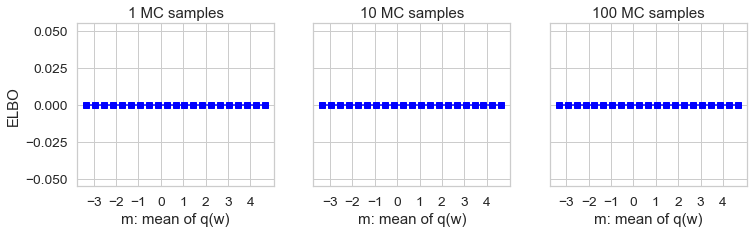

In [56]:
_, subplot_grid = plt.subplots(
    nrows=1, ncols=M, figsize=(12, 3), sharex=True, sharey=True, squeeze=False)

for mm in range(M):
    ax = subplot_grid[0,mm]
    ax.plot(mean_grid_G, elbo_grid_GM[:,mm], 'bs-')
    ax.set_title('%d MC samples' % n_samples_M[mm])
    ax.set_xlabel('m: mean of q(w)'); ax.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4]);
    if mm == 0:
        ax.set_ylabel("ELBO")
        
print("Best w_mean: " + str(mean_grid_G[elbo_grid_GM[:,-1].argmax()]))

<a name="problem-1b"></a>

## Prep for 1b

In [57]:
grad_m_grid_GM = np.zeros((G, M))

for gg, w_mean in enumerate(mean_grid_G):
    cur_q_means = copy.deepcopy(ideal_q_means)
    cur_q_means[0]['w'][:] = w_mean
    for mm, n_samples in enumerate(n_samples_M):
        random_state = 10000 * (mm+1) + gg
        _, grad_wrt_m, grad_wrt_rs = fast_elbo_and_grad(
            cur_q_means, ideal_q_realstddevs, 
            n_samples, random_state)
        grad_m_grid_GM[gg, mm] = grad_wrt_m[0]['w']

## Figure 1b

**STATEMENT**: Make a 1 row x 3 column plot of the estimated gradient of the VI loss w.r.t $\tilde{m}$

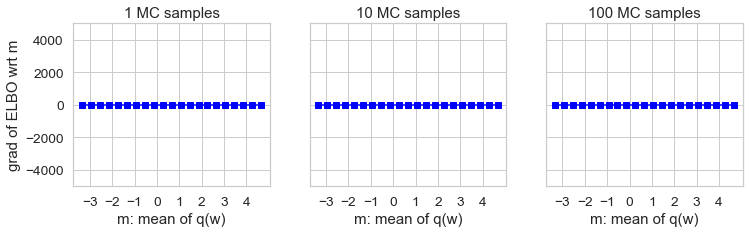

In [58]:
_, subplot_grid = plt.subplots(
    nrows=1, ncols=M, figsize=(12, 3), sharex=True, sharey=True, squeeze=False)

for mm in range(M):
    ax = subplot_grid[0,mm]
    ax.plot(mean_grid_G, grad_m_grid_GM[:,mm], 'bs-')
    ax.set_title('%d MC samples' % n_samples_M[mm])
    ax.set_xlabel('m: mean of q(w)'); ax.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4]);
    if mm == 0:
        ax.set_ylabel('grad of ELBO wrt m');
    ax.set_ylim([-5000, 5000]);

<a name="problem-1d"></a>

<a name="problem-1c"></a>

## Prep for 1c

In [59]:
ideal_w_realstddev = ideal_q_realstddevs[0]['w'].flatten()[0]
realstddev_grid_G = np.linspace(ideal_w_realstddev - 5, ideal_w_realstddev + 3, G)

elbo2_grid_GM = np.zeros((G, M))
    
for gg, w_realstddev in enumerate(realstddev_grid_G):
    cur_q_realstddevs = copy.deepcopy(ideal_q_realstddevs)
    cur_q_realstddevs[0]['w'][:] = w_realstddev
    for mm, n_mc_samples in enumerate(n_samples_M):
        random_state = 10000 * (mm+1) + gg
        elbo2_grid_GM[gg, mm], _, _ = fast_elbo_and_grad(
            ideal_q_means, cur_q_realstddevs, n_mc_samples, random_state)
        
print("Best realstddev for w: " + str(realstddev_grid_G[elbo2_grid_GM[:,-1].argmax()]))
print("Best stddev for w    : " + str(softplus(realstddev_grid_G[elbo2_grid_GM[:,-1].argmax()])))

Best realstddev for w: -7.9995032858469886
Best stddev for w    : 0.00033551783


## Figure 1c

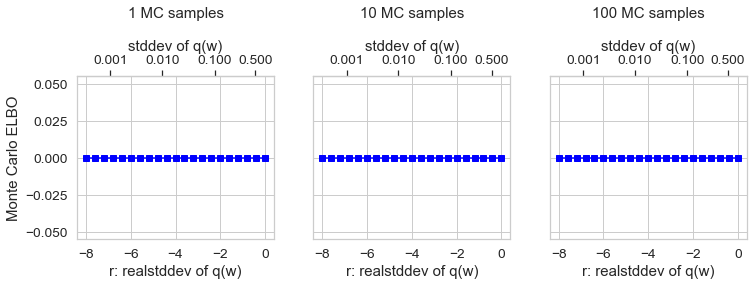

In [60]:
_, subplot_grid = plt.subplots(
    nrows=1, ncols=M, figsize=(12, 3),
    sharex=True, sharey=True, squeeze=False)
for mm in range(M):
    ax = subplot_grid[0,mm]
    ax.plot(realstddev_grid_G, elbo2_grid_GM[:,mm], 'bs-')
    ax.set_title('%d MC samples\n' % n_samples_M[mm])
    ax.set_xlabel('r: realstddev of q(w)')
    xticks = np.asarray([-8, -6, -4, -2, 0]);
    ax2 = ax.secondary_xaxis('top', functions=(softplus, invsoftplus))
    ax.set_xticks(xticks)
    ax2.set_xticks([0.001, 0.01, 0.1, 0.5])
    ax2.set_xlabel('stddev of q(w)')
subplot_grid[0,0].set_ylabel('Monte Carlo ELBO');
#plt.ylim([-200, -140]);

<a name="problem-1d"></a>

## Prep for 1d

In [61]:
grad_rs_grid_GM = np.zeros((G, M))

for gg, w_realstddev in enumerate(realstddev_grid_G):
    cur_q_rs = copy.deepcopy(ideal_q_realstddevs)
    cur_q_rs[0]['w'][:] = w_realstddev
    for mm, n_samples in enumerate(n_samples_M):
        random_state = 10000 * (mm+1) + gg
        _, grad_wrt_m, grad_wrt_rs = fast_elbo_and_grad(
            ideal_q_means, cur_q_rs, 
            n_samples, random_state)
        grad_rs_grid_GM[gg, mm] = grad_wrt_rs[0]['w']

## Figure 1d

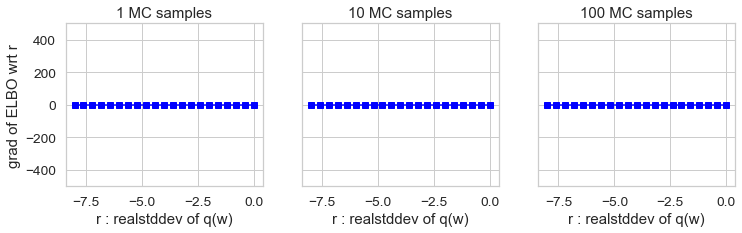

In [62]:
_, subplot_grid = plt.subplots(nrows=1, ncols=M, figsize=(12, 3), sharex=True, sharey=True, squeeze=False)

for mm in range(M):
    ax = subplot_grid[0,mm]
    ax.plot(realstddev_grid_G, grad_rs_grid_GM[:,mm], 'bs-')
    ax.set_title('%d MC samples' % n_samples_M[mm])
    ax.set_xlabel('r : realstddev of q(w)');
    if mm == 0:
        ax.set_ylabel('grad of ELBO wrt r');
    ax.set_ylim([-500, 500]);

<a name="problem-1e"></a>

## Problem 1e

**STATEMENT**: 

* Does Figure 1b look plausible as the gradient of the function in Figure 1a?
* What about Figure 1d as the gradient of the function in Figure 1c?
* Are the 1 sample estimates trustworthy? How many samples would you recommend?

**SOLUTION**: 

TODO WRITE ME

<a name="run_bbvi"></a>

# Problem 2: NN regression on COVID-19 data with linear model (arch [ ])

Let's use BBVI to estimate a posterior over weights for the linear model.

We'll need to carefully tune the following:

* `n_mc_samples` : Number of MC samples 
* `step_size_m` : step_size for the mean parameters of q
* `step_size_rs` : step_size for the realstddev parameters of q
* `n_iters` : how long to run the optimization

The code below offers a "multi-phase" approach to calling the gradient ascent.

Each phase uses a constant setting (num samples, step size etc), and then its result becomes the start of the next phase.

In [63]:
arch0 = []

S_by_phase = {0:10, 1:10, 2:10}
ssm_by_phase = {0:0.001, 1:0.001, 2:0.001}
ssr_by_phase = {0:0.001, 1:0.001, 2:0.001}
n_iters_by_phase = {0:10, 1:10, 2:10}

In [64]:
chain_list = [1,2,3]

# Preallocate where to store results
qm_by_chain = {}
qrs_by_chain = {}
history_by_chain = {}

## Prep for 2a: Run the experiments

In [65]:
for chain_id in chain_list:
    random_state = 100 * rep + chain_id
    
    # Initialize the m and r parameters of q
    q_means = fill_q_params_with_draws_from_normal(
        1, 1, arch0,
        mean=0.0,
        stddev=0.2,
        random_state=random_state)
    q_rs = fill_q_params_with_draws_from_normal(
        1, 1, arch0,
        mean=invsoftplus(0.1), # typical stddev should be 0.1
        stddev=0.2,
        random_state=random_state)
    print()
    for phase in S_by_phase.keys():
        print("Chain %d/%d phase %d" % (chain_id, len(chain_list), phase))
        q_means, q_rs, hist = optimize_q_via_stochastic_gradient_ascent(
            q_means, q_rs,
            n_mc_samples=S_by_phase[phase],
            step_size_m=ssm_by_phase[phase],
            step_size_rs=ssr_by_phase[phase],
            random_state=random_state,
            print_every=100,
            n_iters=n_iters_by_phase[phase])
        qm_by_chain[chain_id] = q_means
        qrs_by_chain[chain_id] = q_rs
        history_by_chain[(chain_id, phase)] = hist


Chain 1/3 phase 0
S =     10 | step_size of m 0.001 | step_size of rs 0.001
iter      0/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      1/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      2/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter     10/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
Chain 1/3 phase 1
S =     10 | step_size of m 0.001 | step_size of rs 0.001
iter      0/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      1/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      2/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter     10/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
Chain 1/3 phase 2
S =     10 | step_size of m 0.001 | step_size of rs 0.001
iter      0/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      1/10 after   0.0 sec  ELBO  0.000000e+00 | [ 0.063] | [-2.189]
iter      2/10 after   0.0 sec  ELBO  0.0

<a id="problem-2a"></a>

## Figure 2a : ELBO, means, and realstddevs over iterations

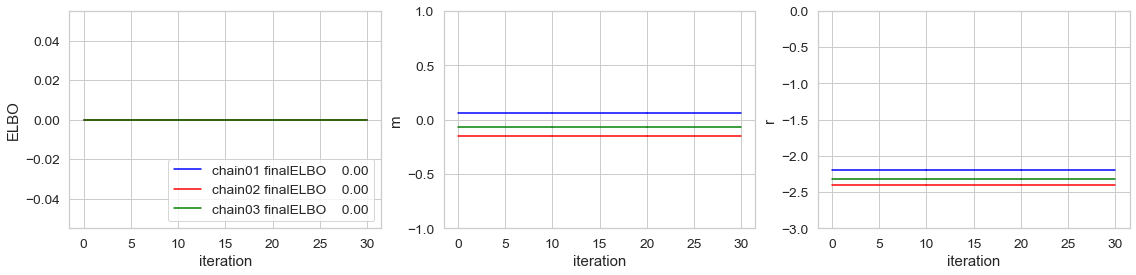

In [66]:
color_by_chain = {1:'b', 2:'r', 3:'g'}
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(3*W+1, H),
                         sharex=True, sharey=False)
for chain in chain_list:
    color = color_by_chain[chain]
    M = 0
    for rep in [0,1,2]:
        iter_T = history_by_chain[(chain,rep)]['iter']
        elbo_T = history_by_chain[(chain,rep)]['elbo']
        label = 'chain%02d finalELBO % 7.2f' % (chain, elbo_T[-10:].mean()) if rep == 2 else None                                                if rep == 2 else None
        axgrid[0].plot(M + iter_T, elbo_T, color=color, linestyle='-', label=label)
        
        m_T = [mlist[-1]['w'].flatten() for mlist in history_by_chain[(chain,rep)]['q_m']]
        axgrid[1].plot(M + iter_T, m_T, color=color, linestyle='-')
        
        rs_T = [rlist[-1]['w'].flatten() for rlist in history_by_chain[(chain,rep)]['q_rs']]
        axgrid[2].plot(M + iter_T, rs_T, color=color, linestyle='-')

        M += iter_T.max();

axgrid[0].set_ylabel("ELBO"); axgrid[0].legend(loc='lower right');
axgrid[1].set_ylabel("m"); axgrid[1].set_ylim([-1.0, 1.0]);
axgrid[2].set_ylabel("r"); axgrid[2].set_ylim([-3.0, 0.0]);
for ax in axgrid:
    ax.set_xlabel('iteration');
#axgrid[0].set_ylim([-250, -140]); # TODO use these ylims if possible

### **Caption for Fig 2a:**  TODO Write this

TODO

* the specific number of Monte Carlo samples and step-sizes used
* 1-2 sentences summarizing your strategy for selecting these values
* your assessment of whether the plots indicate each chain has "converged"

## Prep for Fig 2b

Given the optimal $q$ from each chain above, let's look at its posterior predictive by:

* Drawing $S$ samples of weights/biases from q
* Drawing $S$ samples of $y_*$ at each of the $T$ test inputs $x_*$ defined above (see defn of x_grid_T1)

We can then *reuse* the posterior predictive visualization tools from HW2.

The following code works out of the box. No need to edit it.

In [67]:
S = 200
opts = {'n_samples_burnin':0, 'n_samples_keep':S}
history0_nn_samples_by_chain = {}
history0_y_ST_by_chain = {}
for chain in chain_list:
    # Draw S different weight/bias samples
    history0_nn_samples_by_chain[chain] = sample_nn_params_from_q(
        qm_by_chain[chain],
        qrs_by_chain[chain],
        n_samples=S,
        random_state=random_state)
    
    # Draw y_* values for each of the S weights
    y_ST = np.zeros((S,T))
    prng = np.random.RandomState(1000 * chain + 1)
    for ss in range(S):
        nn_ss = history0_nn_samples_by_chain[chain][ss]
        f_ss_T = predict_f_given_x(x_grid_T1, nn_ss)        
        y_ST[ss] = prng.normal(f_ss_T, model_hypers['tau'])
    history0_y_ST_by_chain[chain] = y_ST

<a id="problem-2b"></a>

## Fig. 2b: Posterior predictive visuals via optimal q for arch []

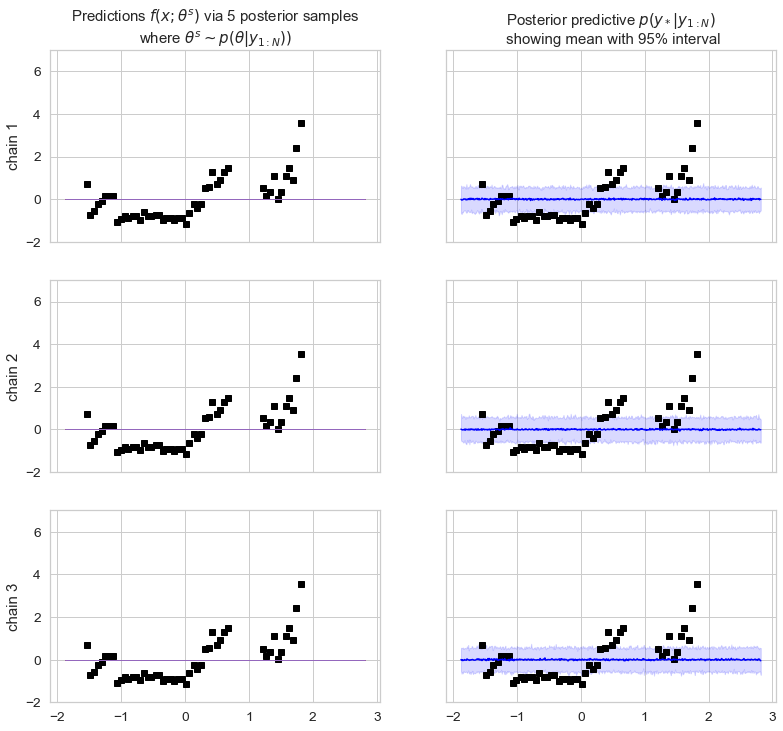

In [68]:
viz_utils.show_posterior_predictive_samples_and_intervals(
    history0_nn_samples_by_chain, history0_y_ST_by_chain,
    x_grid_T=x_grid_T, x_NF=x_NF, y_N=y_N, sampler_options=opts)
plt.ylim([-2, 7]);

### **Caption for Fig 2b:** TODO Write this

TODO summarize how these estimated posteriors compare to the exact posterior for arch [] from HW2.


# Problem 3: NN regression on COVID-19 data with arch [8]

Same goals as problem 2, now with a more sophisticated model (1 hidden layer, 8 units).

In [69]:
arch8 = [8]

ss = 1e-6
ssm_by_phase = {0:ss, 1:ss, 2:ss}
ssr_by_phase = {0:ss, 1:ss, 2:ss}
S_by_phase = {0:10, 1:10, 2:10}
n_iters_by_phase = {0:50, 1:50, 2:50}

chain_list = [1,2,3]

In [70]:
qm8_by_chain = {}
qr8_by_chain = {}
history8_by_chain = {}

In [71]:
for chain_id in chain_list:
    print("Chain %d/%d" % (chain_id, len(chain_list)))
    random_state = 100 * rep + chain_id
    q8_means = fill_q_params_with_draws_from_normal(
        1, 1, arch8,
        mean=0.0,
        stddev=0.2,
        random_state=random_state)
    q8_rs = fill_q_params_with_draws_from_normal(
        1, 1, arch8,
        mean=invsoftplus(0.1), # typical stddev should be 0.1
        stddev=0.2,
        random_state=random_state)

    for phase in S_by_phase.keys():
        q8_means, q8_rs, hist8 = optimize_q_via_stochastic_gradient_ascent(
            q8_means, q8_rs,
            n_mc_samples=S_by_phase[phase],
            step_size_m=ssm_by_phase[phase],
            step_size_rs=ssr_by_phase[phase],
            random_state=random_state,
            print_every=100,
            n_iters=n_iters_by_phase[phase])
        qm8_by_chain[chain_id] = q8_means
        qr8_by_chain[chain_id] = q8_rs
        history8_by_chain[(chain_id, phase)] = hist8

Chain 1/3
S =     10 | step_size of m 1e-06 | step_size of rs 1e-06
iter      0/50 after   0.1 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter      1/50 after   0.1 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter      2/50 after   0.1 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter     50/50 after   0.1 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
S =     10 | step_size of m 1e-06 | step_size of rs 1e-06
iter      0/50 after   0.0 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter      1/50 after   0.0 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter      2/50 after   0.0 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter     50/50 after   0.0 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
S =     10 | step_size of m 1e-06 | step_size of rs 1e-06
iter      0/50 after   0.0 sec  ELBO  0.000000e+00 | [-0.010  0.382] | [-2.262 -1.871]
iter      1/50 after   0.0 sec  E

<a id="problem-3a"></a>

## Fig 3a

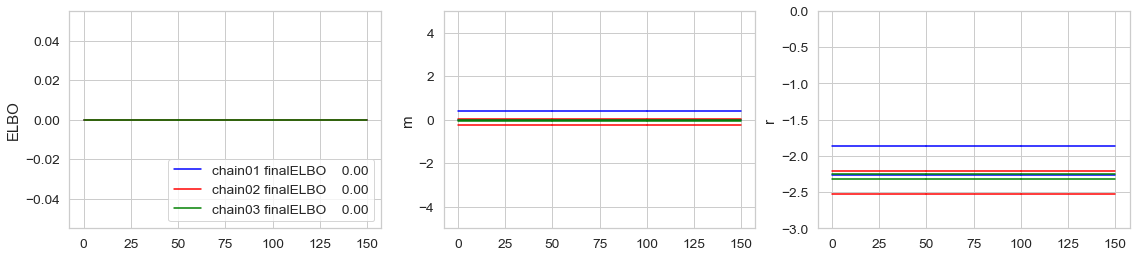

In [72]:
color_by_chain = {1:'b', 2:'r', 3:'g'}
_, axgrid = plt.subplots(nrows=1, ncols=3, figsize=(3*W+1, H),
                         sharex=True, sharey=False)

for chain in chain_list:
    color = color_by_chain[chain]
    M = 0
    for rep in [0,1,2]:
        iter_T = history8_by_chain[(chain,rep)]['iter']
        elbo_T = history8_by_chain[(chain,rep)]['elbo']
        label = 'chain%02d finalELBO % 7.2f' % (chain, elbo_T[-5:].mean()) if rep == 2 else None                                                if rep == 2 else None
        axgrid[0].plot(M + iter_T, elbo_T, color=color, linestyle='-', label=label)
        
        # Show means of first 2 weights of last layer
        m_T = [mlist[-1]['w'].flatten()[:2] for mlist in history8_by_chain[(chain,rep)]['q_m']]
        axgrid[1].plot(M + iter_T, m_T, color=color, linestyle='-')
        
        # Show realstddevs of first 2 weights of last layer
        rs_T = [rlist[-1]['w'].flatten()[:2] for rlist in history8_by_chain[(chain,rep)]['q_rs']]
        axgrid[2].plot(M + iter_T, rs_T, color=color, linestyle='-')

        M += iter_T.max();

axgrid[0].set_ylabel("ELBO"); axgrid[0].legend(loc='lower right')
axgrid[1].set_ylabel("m"); axgrid[1].set_ylim([-5.0, 5.0]);
axgrid[2].set_ylabel("r"); axgrid[2].set_ylim([-3.0, 0.0]);

#axgrid[0].set_ylim([-400, -120]); # TODO try to use these lims when code is working

### **Caption for Fig 3a**: TODO WRITE THIS 

TODO 

* the specific number of Monte Carlo samples and step-sizes used
* 1-2 sentences summarizing your strategy for selecting these values
* your assessment of whether the plots indicate each chain has "converged"

## Prep for Fig 3b

Again, provided for you out-of-the-box so you can immediately visualize the posteriors from your BBVI runs

In [73]:
S = 200
B = 0
opts = {'n_samples_burnin':B, 'n_samples_keep':S}
history8_nn_samples_by_chain = {}
history8_y_ST_by_chain = {}
for chain in chain_list:
    history8_nn_samples_by_chain[chain] = sample_nn_params_from_q(
        qm8_by_chain[chain],
        qr8_by_chain[chain],
        n_samples=S,
        random_state=random_state)
    y_ST = np.zeros((S,T))
    prng = np.random.RandomState(1000 * chain + 1)
    for ss in range(S):
        nn_ss = history8_nn_samples_by_chain[chain][B+ss]
        f_ss_T = predict_f_given_x(x_grid_T1, nn_ss)        
        y_ST[ss] = prng.normal(f_ss_T, model_hypers['tau'])
    history8_y_ST_by_chain[chain] = y_ST

<a id="problem-3b"></a>

## Fig 3b: Posterior predictive via optimal q for arch [8]

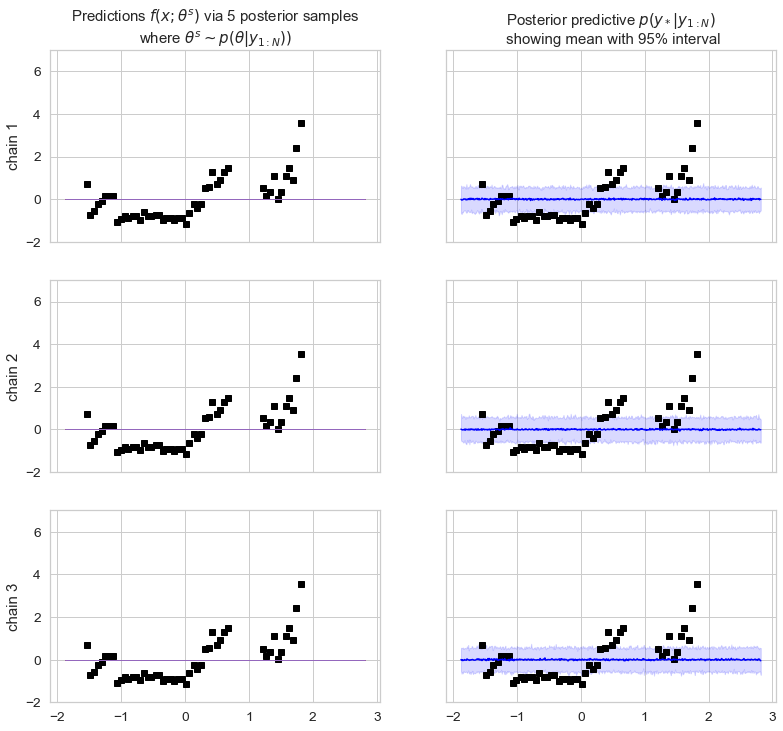

In [74]:
viz_utils.show_posterior_predictive_samples_and_intervals(
    history8_nn_samples_by_chain, history8_y_ST_by_chain,
    x_grid_T=x_grid_T, x_NF=x_NF, y_N=y_N, sampler_options=opts)
plt.ylim([-2, 7]);

### **Caption for Fig 3b:** TODO WRITE THIS

TODO summarize whether the *best* of your chains with arch [8] visually fits the data better than the simpler linear model, and whether the corresponding ELBO of that chain suggests the fit is better.
